# Setup

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
import os
from glob import glob

import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from parse import parse
import pickle as pkl

import utils
import matplotlib.pyplot as plt, numpy
sns.set(style='ticks', context='notebook', font_scale=1.5, font='serif')
plt.rcParams.update(utils.rcParams)

numpy.random.seed(1234)

In [3]:
alphas = np.delete(np.arange(0, 4.5, 0.5), 4)

C_SI = 299792458
HPLANCK_SI = 4.13567e-15

def pev_scale(alpha):
    return (1E-12)**(2.-alpha)

def alpha_str(alpha):
    return str(alpha).replace('.', 'p').replace('p0', '')

# Function to convert the \lambda_A parameter to A
def A_from_lambdaA(lambdaA, alpha):
    return (lambdaA/(HPLANCK_SI*C_SI))**(alpha-2.0)

def normalize(y, x):
    return y/trapz(y, x)

# Load data

In [4]:
# containers for PDFs, upper limits and quantiles from different runs
joint_pdf_dict = {}
ul_dict = {}
quant_dict = {}
mg_ul_dict={}

In [5]:


sup_events_O3a=[
#23 GWTC-2 events and  8 GWTC-1 events
'GW190828B',
'GW190910A',
'GW190512A',
'GW190412A',
'GW190602A',
'GW190720A',
'GW190503A',
'GW190828A',
'GW190728A',
'GW190513A',
'GW190915A',
'GW190421A',
'GW190708A',
'GW190924A',
'GW190408A',
'GW190517A',
'GW190707A',
'GW190814A',
'GW190519A',
'GW190727A',
'GW190521B',
'GW190630A',
'GW190706A',
#
'GW150914A',
'GW151226A',
'GW170818A',
'GW170809A',
'GW170104A',
'GW170608A',
'GW170814A',
'GW170823A'
    ]

sup_events_O3b=[
#12 GWTC-3 events (S191109 and S200313bj are not included in the list)
'GW191222A',
'GW200129A',
'GW191129A',
'GW191204B',
'GW191215A',
'GW191216A',
'GW200219A',
'GW200224B',
'GW200225A',
'GW200311B',
'GW200202A',
'GW200208A'
]

sup_events = sup_events_O3a+sup_events_O3b
sup_events_excl2evnt = sup_events.copy()
sup_events_excl2evnt.remove('GW200219A')
sup_events_excl2evnt.remove('GW200225A')

In [6]:
input_paths = {
    'samples': 'gwtc3_data/{event}/liv_{event}_{par}.dat.gz',
    'pdf': 'gwtc3_data/{event}/liv_{event}_{par}_pdf.dat.gz'
}

def load_data(param, event_list, data_path=input_paths['samples'], data_dict=None):
    if data_dict is None:
        data_dict = {}
    #paths = glob(data_path.format(par=param, event='*'))
    paths = list(data_path.format(par=param, event=e) for e in event_list)
    for path in paths:
        label = parse(data_path, path).named['event']
        data_dict[label] = np.loadtxt(path)
    return data_dict

# GWTC-2 and GWTC-3 (12 O3b events)

In [7]:
# amplitude PDFs
event_pdfs = {}
for alpha in alphas:
    event_pdfs[alpha] = load_data('alpha'+ alpha_str(alpha), sup_events,
                                  data_path=input_paths['pdf'])

In [8]:
# number of gridpoints on which to evaluate PDFs
nbins = 5000

run = 'GWTC-3 (43 events)'
pdfs, uls, quants = [], [], []
for a in alphas:
    # interpolate PDF grids
    print(a)
    kdes = [interp1d(v[0], v[1], fill_value=0, bounds_error=False)
            for v in event_pdfs[a].values()]
    # for amplitude array on which to evaluate the interpolants
    A_min = min([min(A) for A, _ in event_pdfs[a].values()])
    A_max = max([max(A) for A, _ in event_pdfs[a].values()])
    amps_array = np.linspace(A_min, A_max, nbins)
    # multipliy PDFs
    joint_pdf_array = utils.multiply_likelihood_kdes(kdes, amps_array)
    # compute derived quantities (upper limits and quantiles)
    uls.append(utils.get_negpos_uls_from_pdf(joint_pdf_array, amps_array))
    quants.append(utils.get_quantile_from_pdf(joint_pdf_array, amps_array))
    pdfs.append((joint_pdf_array, amps_array))
joint_pdf_dict[run] = pdfs
quant_dict[run] = quants
# rescale upper limits by (dimensionful) alpha-dependent factor
ul_dict[run] = np.array(uls) / pev_scale(alphas).reshape(8, 1)

0.0
0.5
1.0
1.5
2.5
3.0
3.5
4.0


In [23]:
# load samples
mg_pdfs = load_data('mg',sup_events)

nbins = 5000
kdes = [interp1d(v[0], v[1], fill_value=0, bounds_error=False)
            for v in mg_pdfs.values()]
# for amplitude array on which to evaluate the interpolants
mg_min = min([min(mg) for mg, _ in mg_pdfs.values()])
mg_max = max([max(mg) for mg, _ in mg_pdfs.values()])
amps_array = np.linspace(mg_min, mg_max, nbins)
# multipliy PDFs
joint_pdf_array = utils.multiply_likelihood_kdes(kdes, amps_array)

#compute upper limit
mg_ul_dict['GWTC-3 (43 events)'] = utils.get_ul_from_pdf(joint_pdf_array, amps_array)


# GWTC-2 and GWTC-3 (10 O3b events)

In [24]:
# amplitude PDFs
event_pdfs = {}
for alpha in alphas:
    event_pdfs[alpha] = load_data('alpha'+ alpha_str(alpha), sup_events_excl2evnt,
                                  data_path=input_paths['pdf'])

In [25]:
# number of gridpoints on which to evaluate PDFs
nbins = 5000

run = 'GWTC-3 (41 events)'
pdfs, uls, quants = [], [], []
for a in alphas:
    # interpolate PDF grids
    print(a)
    kdes = [interp1d(v[0], v[1], fill_value=0, bounds_error=False)
            for v in event_pdfs[a].values()]
    # for amplitude array on which to evaluate the interpolants
    A_min = min([min(A) for A, _ in event_pdfs[a].values()])
    A_max = max([max(A) for A, _ in event_pdfs[a].values()])
    amps_array = np.linspace(A_min, A_max, nbins)
    # multipliy PDFs
    joint_pdf_array = utils.multiply_likelihood_kdes(kdes, amps_array)
    # compute derived quantities (upper limits and quantiles)
    uls.append(utils.get_negpos_uls_from_pdf(joint_pdf_array, amps_array))
    quants.append(utils.get_quantile_from_pdf(joint_pdf_array, amps_array))
    pdfs.append((joint_pdf_array, amps_array))
joint_pdf_dict[run] = pdfs
quant_dict[run] = quants
# rescale upper limits by (dimensionful) alpha-dependent factor
ul_dict[run] = np.array(uls) / pev_scale(alphas).reshape(8, 1)

0.0
0.5
1.0
1.5
2.5
3.0
3.5
4.0


In [27]:
# load samples
mg_pdfs = load_data('mg',sup_events_excl2evnt)

nbins = 5000
kdes = [interp1d(v[0], v[1], fill_value=0, bounds_error=False)
            for v in mg_pdfs.values()]
# for amplitude array on which to evaluate the interpolants
mg_min = min([min(mg) for mg, _ in mg_pdfs.values()])
mg_max = max([max(mg) for mg, _ in mg_pdfs.values()])
amps_array = np.linspace(mg_min, mg_max, nbins)
# multipliy PDFs
joint_pdf_array = utils.multiply_likelihood_kdes(kdes, amps_array)

#compute upper limit
mg_ul_dict['GWTC-3 (41 events)'] = utils.get_ul_from_pdf(joint_pdf_array, amps_array)

# GWTC-2

In [28]:
# amplitude PDFs
event_pdfs = {}
for alpha in alphas:
    event_pdfs[alpha] = load_data('alpha'+ alpha_str(alpha), sup_events_O3a,
                                  data_path=input_paths['pdf'])

In [29]:
# number of gridpoints on which to evaluate PDFs
nbins = 5000

run = 'GWTC-2'
pdfs, uls, quants = [], [], []
for a in alphas:
    # interpolate PDF grids
    print(a)
    kdes = [interp1d(v[0], v[1], fill_value=0, bounds_error=False)
            for v in event_pdfs[a].values()]
    # for amplitude array on which to evaluate the interpolants
    A_min = min([min(A) for A, _ in event_pdfs[a].values()])
    A_max = max([max(A) for A, _ in event_pdfs[a].values()])
    amps_array = np.linspace(A_min, A_max, nbins)
    # multipliy PDFs
    joint_pdf_array = utils.multiply_likelihood_kdes(kdes, amps_array)
    # compute derived quantities (upper limits and quantiles)
    uls.append(utils.get_negpos_uls_from_pdf(joint_pdf_array, amps_array))
    quants.append(utils.get_quantile_from_pdf(joint_pdf_array, amps_array))
    pdfs.append((joint_pdf_array, amps_array))
joint_pdf_dict[run] = pdfs
quant_dict[run] = quants
# rescale upper limits by (dimensionful) alpha-dependent factor
ul_dict[run] = np.array(uls) / pev_scale(alphas).reshape(8, 1)

0.0
0.5
1.0
1.5
2.5
3.0
3.5
4.0


In [30]:
# load samples
mg_pdfs = load_data('mg',sup_events_O3a)

nbins = 5000
kdes = [interp1d(v[0], v[1], fill_value=0, bounds_error=False)
            for v in mg_pdfs.values()]
# for amplitude array on which to evaluate the interpolants
mg_min = min([min(mg) for mg, _ in mg_pdfs.values()])
mg_max = max([max(mg) for mg, _ in mg_pdfs.values()])
amps_array = np.linspace(mg_min, mg_max, nbins)
# multipliy PDFs
joint_pdf_array = utils.multiply_likelihood_kdes(kdes, amps_array)

#compute upper limit
mg_ul_dict['GWTC-2'] = utils.get_ul_from_pdf(joint_pdf_array, amps_array)

In [31]:
ul_style = {
    'GWTC-2': {
        'c': 'gray',
        'marker': '^',
        'ls': 'none',
        'label': 'GWTC-2',
    },
    'GWTC-3 (41 events)': {
        'marker': 'D',
        'c': sns.color_palette("Paired")[1],#sns.color_palette('deep')[3],
        'ls': 'none',
        'label': 'GWTC-3 (41 events)',
        'alpha' : 1,
        'mfc' : 'none',
        'markeredgewidth' : 1.2
    },
    'GWTC-3 (43 events)': {
        'marker': 'D',
        'c': sns.color_palette("Paired")[5],
        'ls': 'none',
        'label': 'GWTC-3 (43 events)',
        'alpha' : 1
    }
}

runs = list(ul_style.keys())

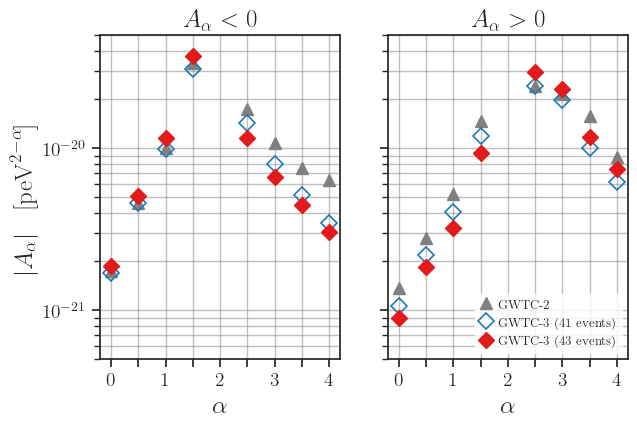

In [32]:
fig, axs = plt.subplots(1, 2, sharey=True)
for i, ax in enumerate(axs):
    ax.set_yscale('log')
    for k in runs:
        kw = ul_style[k].copy()
        ax.plot(alphas, ul_dict[k][:,i], markersize=8, **kw)
    ax.set_ylim(5E-22, 5E-20)
    #ax.set_yticks([5*1e-22,1e-21,5*1e-21, 1e-20, 5*1e-20])
    #ax.set_yticklabels([r'$5\times10^{-22}$',r'$10^{-21}$', r'$5\times10^{-21}$',r'$10^{-20}$', r'$5\times10^{-20}$'])
    ax.set_xticks(np.arange(0, 4.5, 0.5))
    ax.set_xticklabels([0,'',1,'',2,'',3,'',4])
    ax.grid(which='both', linestyle='-',color='gray', alpha=0.5)
    ax.tick_params(axis='both', labelsize=14)
axs[0].set_ylabel(r'$|A_\alpha| \quad [\mathrm{peV}^{2-\alpha}]$');
for i, s in enumerate(['<', '>']):
    axs[i].set_title(r'$A_\alpha %s 0$' % s);
    axs[i].set_xlabel(r'$\alpha$')
axs[1].legend(loc='lower right', handletextpad=0.5, handlelength=1., edgecolor='w',fontsize=9)
fig.savefig('liv_amp_joint_uls.pdf', bbox_inches='tight')

In [33]:
 style = {
    'GWTC-2': {
        'edgecolor': 'gray',
        'facecolor': 'gray',
        'linestyle': '-',
        'alpha': 0.4,
        'zorder': -100,
    },
     'GWTC-3 (43 events)': {
        'edgecolor': sns.color_palette("Paired")[5],
        'facecolor': 'none',# sns.color_palette('colorblind')[0],
        #'color': sns.color_palette('colorblind')[0],
        'alpha': 1,
         'linewidth' : 1,
    },
    'GWTC-3 (41 events)': {
        'color': sns.color_palette("Paired")[1],#sns.color_palette('deep')[1],
        'alpha': 1.,
        'zorder': -100,
        'edgecolor': sns.color_palette("Paired")[1],#sns.color_palette('deep')[1],
        'facecolor': 'none',
        'linewidth' : 1.5,
    }

}
runs = list(style.keys())

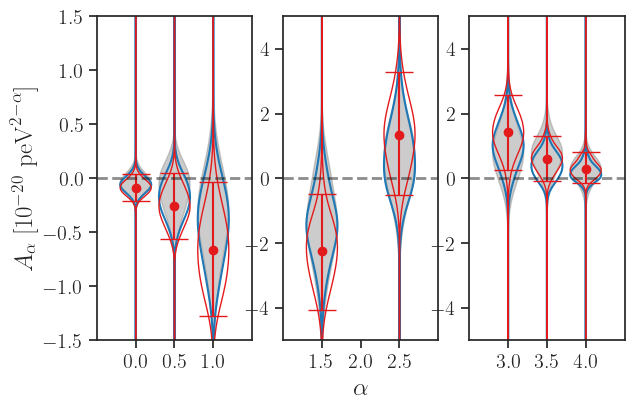

In [34]:
PLOT_FACTOR = 1E-20
def plot_scale(alpha):
    return PLOT_FACTOR*pev_scale(alpha)

fig, axs = plt.subplots(1,3)
alpha_sets = [alphas[:3], alphas[[3,4]], alphas[5:]]

for ax, alpha_set in zip(axs,alpha_sets):
    for k in runs:
        pdf_amps_arrays = joint_pdf_dict[k]
        uls_rescaled = ul_dict[k]
        for alpha in alpha_set:
            # plot violin
            pdf_array, amps_array = pdf_amps_arrays[np.where(alphas==alpha)[0][0]]
            x = pdf_array[np.isfinite(pdf_array)]
            x *= 0.2/x.max()
            y = amps_array[np.isfinite(pdf_array)]/plot_scale(alpha)
            ax.fill_betweenx(y, alpha - x, alpha + x, **style[k])
            #ax.plot( alpha - x, y, **style[k])
            #ax.plot( alpha + x, y, **style[k])
            if k == 'GWTC-3 (43 events)' :#or k == 'GWTC-3 (43 events)':
                # plot median and 90% CI
                med = utils.get_ul_from_pdf(pdf_array, amps_array, p=0.5) / plot_scale(alpha)
                left, right = utils.get_sym_interval_from_pdf(pdf_array, amps_array) / plot_scale(alpha)
                ax.errorbar([alpha], [med], yerr=[[med-left], [right-med]],
                            fmt='o', capsize=10, c=style[k]['edgecolor'],linestyle='-')
    ax.axhline(0, ls='--', c='k', alpha=0.5, lw=2)
    ax.set_xticks(np.arange(alpha_set[0], alpha_set[-1]+0.5, 0.5))

ylims = [1.5, 5, 5]
for ax, ylim in zip(axs, ylims):
    ax.set_ylim(-ylim, ylim);
axs[0].set_xlim(-0.5, 1.5);
axs[1].set_xlim(1, 3);
axs[2].set_xlim(2.5,4.5);

axs[1].set_xlabel(r'$\alpha$');
axs[0].set_ylabel(r'$A_\alpha$ [$10^{%i}$ $\mathrm{peV}^{2-\alpha}$]' % np.log10(PLOT_FACTOR));

fig.savefig('liv_amp_joint_posteriors.pdf', bbox_inches='tight')

# Table

In [35]:
# scale factors for values in table (from O1-2 TGR paper)
SCALE_ALPHA = [1E-45, 1E-38, 1E-32, 1E-26, 1E-14, 1E-8, 1E-2, 1E4]
MG_SCALE = 1E-23

In [36]:
#runs = ['GWTC-2','GWTC-3 (43 events)']
df_dict = {}
for run in runs:
    index = pd.MultiIndex.from_tuples(zip(alphas, [run]*len(alphas)),
                                     names=['alpha', 'run'])
    df_dict[run] = pd.DataFrame({
        'A_m': ul_dict[run][:,0]*pev_scale(alphas),
        'A_p': ul_dict[run][:,1]*pev_scale(alphas),
        'Q': quant_dict[run],
    }, index=index)

# make quantiles a percent
df = pd.concat(df_dict.values()).sort_index()
df['Q'] = (df['Q']*100).map('{:.0f}'.format)

# rescale numbers for ease of display
for alpha, scale in zip(alphas, SCALE_ALPHA):
    for k in ['A_m', 'A_p']:
        df.loc[alpha, k] = df.loc[alpha, k].values / scale

# some pandas gymnastics to get the right columns
pref_runs = ['GWTC-2','GWTC-3 (43 events)']
df_table = df.unstack(0).T.swaplevel(0,1).sort_index().T.reindex(pref_runs)

# add graviton mass (rescaled by some factor for display)
df_table.insert(0, 'mg', [mg_ul_dict[k] / MG_SCALE for k in pref_runs])

# insert buffer columns
j = 0
for i in range(len(alphas)):
    df_table.insert(1+i*3+j, '', '', allow_duplicates=True)
    j += 1

df_table

alpha                     mg         0.0                       0.5            \
                                     A_m       A_p   Q         A_m       A_p   
run                                                                            
GWTC-2              3.088818    1.745602  1.367982  66    0.461132  0.280706   
GWTC-3 (43 events)  2.419280    1.881455  0.889021  86    0.509823  0.185902   

alpha                     ...       3.0             3.5                  \
                     Q    ...       A_p   Q         A_m       A_p   Q     
run                       ...                                             
GWTC-2              66    ...  2.169565  17      0.7565  1.569853  12     
GWTC-3 (43 events)  91    ...  2.332438   2    0.446746  1.164698   7     

alpha                    4.0                
                         A_m       A_p   Q  
run                                         
GWTC-2              0.637395  0.880729  25  
GWTC-3 (43 events)  0.304455  0.738157  15  

[2 rows x 33 columns]

In [37]:
# export table
table_path = 'tab_liv.tex'
table = df_table.to_latex(escape=False, multicolumn=True,
                          multirow=True, float_format="{:0.2f}".format)

# add custom header
header = [
    r'\begin{tabular}{ccc*{7}{cccc}ccc}',
    r'\toprule',
    r'& $m_g$ & & \threec{$|\bar{A}_0|$} & & \threec{$|\bar{A}_{0.5}|$} & & \threec{$|\bar{A}_1|$} & & \threec{$|\bar{A}_{1.5}|$} & & \threec{$|\bar{A}_{2.5}|$} & & \threec{$|\bar{A}_3|$} & & \threec{$|\bar{A}_{3.5}|$} & & \threec{$|\bar{A}_4|$}\\',
    r'\cline{4-6}',
    r'\cline{8-10}',
    r'\cline{12-14}',
    r'\cline{16-18}',
    r'\cline{20-22}',
    r'\cline{24-26}',
    r'\cline{28-30}',
    r'\cline{32-34}',
    r' & [$10^{-23}$ & & $<$ & $>$ & $Q_\text{GR}$ & & $<$ & $>$ & $Q_\text{GR}$ & & $<$ & $>$ & $Q_\text{GR}$ & & $<$ & $>$ & $Q_\text{GR}$ & & $<$ & $>$ & $Q_\text{GR}$ & & $<$ & $>$ & $Q_\text{GR}$ & & $<$ & $>$ & $Q_\text{GR}$ & & $<$ & $>$ & $Q_\text{GR}$\\',
    r'&  eV$/c^2$] ' + ' '.join([(r'& & \twoc{[$10^{%i}$]}' % np.log10(v)) +  ' & [\%]' for v in SCALE_ALPHA]) + r'\\',
    r'\midrule',
]

table2 = '\n '.join(header).replace('run','') + table.split(r'\midrule')[1] 

# lines = table2.splitlines()
# idx = [i for i,l in enumerate(lines) if runs[-1] in l][0]
# lines.insert(idx, '\midrule')
table2 = table2.replace(runs[-1], r'{\bf %s}' % runs[-1])

with open(table_path, 'w') as f:
    f.write(table2)

# Macros

First compute the improvement in the coefficient with respect to past benchmarks.

In [38]:
df2 = df.unstack()
df_table = df.unstack(0).T.swaplevel(0,1).sort_index().T.reindex(runs)
# add graviton mass (rescaled by some factor for display)
df_table.insert(0, 'mg', [mg_ul_dict[k] / MG_SCALE for k in runs])

# Amplitude improvement with respect to GWTC-1
amp_improv = pd.DataFrame({k: df2[k]['GWTC-2']/df2[k]['GWTC-3 (43 events)'] for k in ['A_m', 'A_p']})
print('----------------------------\nGWTC-2 vs GWTC3 (43 events)')
print(amp_improv)
avg_amp_improv = np.average(amp_improv)
min_amp_improv = min(min(amp_improv['A_m']), min(amp_improv['A_p']))
max_amp_improv = max(max(amp_improv['A_m']), max(amp_improv['A_p']))
print('Average: %.2f' % np.average(avg_amp_improv))
print('--------')

# MG improvement with respect to GWTC-2 
mg_improv = float(df_table.loc['GWTC-2', 'mg'])/float(df_table.loc['GWTC-3 (43 events)', 'mg'])

# MG improvement with respect to Solar System, 90% CL from Bernus et al (2020)
# https://journals.aps.org/prd/abstract/10.1103/PhysRevD.102.021501
MG_SOLAR = 3.16E-23
mg_improv_solar = MG_SOLAR/(df_table.loc['GWTC-3 (43 events)', 'mg']*MG_SCALE)
print('MG:', ['%.1f' % r for r in [mg_improv, mg_improv_solar]])


#For 41 event runs
print('----------------------------\nGWTC-2 vs GWTC3 (41 events)')
# Amplitude improvement with respect to GWTC-2
amp_improv_41event = pd.DataFrame({k: df2[k]['GWTC-2']/df2[k]['GWTC-3 (41 events)'] for k in ['A_m', 'A_p']})
print(amp_improv_41event)
avg_amp_improv_41event = np.average(amp_improv_41event)
min_amp_improv_41event = min(min(amp_improv_41event['A_m']), min(amp_improv_41event['A_p']))
max_amp_improv_41event = max(max(amp_improv_41event['A_m']), max(amp_improv_41event['A_p']))
print('Average: %.2f' % np.average(amp_improv_41event))
print('--------')

# MG improvement with respect to GWTC-1 
mg_improv_41event = float(df_table.loc['GWTC-2', 'mg'])/float(df_table.loc['GWTC-3 (41 events)', 'mg'])

# MG improvement with respect to Solar System, 90% CL from Bernus et al (2020)
# https://journals.aps.org/prd/abstract/10.1103/PhysRevD.102.021501
MG_SOLAR = 3.16E-23
mg_improv_solar_41event = MG_SOLAR/(df_table.loc['GWTC-3 (41 events)', 'mg']*MG_SCALE)
print('MG:', ['%.1f' % r for r in [mg_improv_41event, mg_improv_solar_41event]])

----------------------------
GWTC-2 vs GWTC3 (43 events)
            A_m       A_p
alpha                    
0.0    0.927794  1.538750
0.5    0.904493  1.509969
1.0    0.860621  1.620550
1.5    0.909753  1.568404
2.5    1.500357  0.824681
3.0    1.626346  0.930170
3.5    1.693355  1.347863
4.0    2.093556  1.193145
Average: 1.32
--------
MG: ['1.3', '1.3']
----------------------------
GWTC-2 vs GWTC3 (41 events)
            A_m       A_p
alpha                    
0.0    1.023116  1.283583
0.5    1.006117  1.282437
1.0    1.008271  1.304326
1.5    1.090489  1.230153
2.5    1.220670  1.003966
3.0    1.344992  1.087957
3.5    1.473330  1.562646
4.0    1.838423  1.422237
Average: 1.26
--------
MG: ['1.1', '1.2']


/tmp/ipykernel_31466/2953026742.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mg_improv = float(df_table.loc['GWTC-2', 'mg'])/float(df_table.loc['GWTC-3 (43 events)', 'mg'])
/tmp/ipykernel_31466/2953026742.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('MG:', ['%.1f' % r for r in [mg_improv, mg_improv_solar]])
/tmp/ipykernel_31466/2953026742.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mg_improv_41event = float(df_table.loc['GWTC-2', 'mg'])/float(df_table.loc['GWTC-3 (41 events)', 'mg'])
/tmp/ipykernel_31466/2953026742.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
 

In [39]:
min(min(amp_improv['A_m']), min(amp_improv['A_p']))
max(max(amp_improv['A_m']), max(amp_improv['A_p']))

2.0935561323811136

In [40]:
nevents={}
nevents['GWTC-3 (43 events)'] = len(sup_events)
nevents['GWTC-3 (41 events)'] = len(sup_events_excl2evnt)
nevents['GWTC-2'] = len(sup_events_O3a)

macros = [
    r'\newcommand{\LivMgUL}{\ensuremath{%.2f \times 10^{%i}}}' % \
    (df_table.loc['GWTC-3 (43 events)', 'mg'], np.log10(MG_SCALE)),
    r'\newcommand{\LivMgSolarUL}{\ensuremath{%s}}}' % \
    '{:.2e}'.format(MG_SOLAR).replace('e', r'\times 10^{'),
    r'\newcommand{\LivMgULFoutyoneEvents}{\ensuremath{%.2f \times 10^{%i}}}' % \
    (df_table.loc['GWTC-3 (41 events)', 'mg'], np.log10(MG_SCALE)),
]

cases_43events = ''.join([
    r'{AMP}{%.1f}' % np.average(amp_improv),
    r'{AMP_min}{%.1f}' % np.average(min_amp_improv),
    r'{AMP_max}{%.1f}' % np.average(max_amp_improv),
    r'{MG}{%.1f}' % mg_improv,
    r'{EXP}{%.1f}' % np.sqrt(nevents['GWTC-3 (43 events)']/nevents['GWTC-2']),
    r'{MG_SOLAR}{%.1f}' %  mg_improv_solar,
])
cases_41events = ''.join([
    r'{AMP}{%.1f}' % np.average(amp_improv_41event),
    r'{AMP_min}{%.1f}' % np.average(min_amp_improv_41event),
    r'{AMP_max}{%.1f}' % np.average(max_amp_improv_41event),
    r'{MG}{%.1f}' % mg_improv_41event,
    r'{EXP}{%.1f}' % np.sqrt(nevents['GWTC-3 (41 events)']/nevents['GWTC-2']),
    r'{MG_SOLAR}{%.1f}' %  mg_improv_solar_41event,
])
macros.append(r'\newcommand{\LivImprov}[1]{\IfEqCase{#1}{%s}}' % cases_43events)
macros.append(r'\newcommand{\LivImprovFoutyoneEvents}[1]{\IfEqCase{#1}{%s}}' % cases_41events)

cases = ''.join(['{%s}{%i}' % (r,n) for r,n in nevents.items()])
macros.append(r'\newcommand{\LivEvents}[1]{\IfEqCase{#1}{%s}}' % cases)

/tmp/ipykernel_31466/1598882513.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r'\newcommand{\LivMgUL}{\ensuremath{%.2f \times 10^{%i}}}' % \
/tmp/ipykernel_31466/1598882513.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r'\newcommand{\LivMgULFoutyoneEvents}{\ensuremath{%.2f \times 10^{%i}}}' % \
/tmp/ipykernel_31466/1598882513.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r'{MG_SOLAR}{%.1f}' %  mg_improv_solar,
/tmp/ipykernel_31466/1598882513.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r'{MG_SOLAR}{%.1f}' %  mg_improv_solar_41event,


In [41]:
 with open('liv_macros.tex', 'w') as f:
    f.write('\n'.join(macros))